This notebook gives an overview of some basic ways to evaluate the screen recognition model trained in the prior notebook - 1. Train_Screen_Recognizer_VINS including `mAP` or "mean average precision", `AUC` or "area under the curve", and creating confusion matrices to understand where the model confuses very classes with each other. 

In [1]:
import os
import sys
import json
import warnings
from tqdm import tqdm 
from typing import Optional
from dataclasses import dataclass
import altair as alt
from math import ceil 

from collections import namedtuple, defaultdict
warnings.simplefilter(action='ignore', category=FutureWarning)

from PIL import ImageDraw
from screenrecognition.ui_datasets import *
from screenrecognition.ui_models import *
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import *
import torch
import datetime
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
CHECKPOINTS_DIR = "./downloads/checkpoints/"
PREDICTIONS_DIR = "./predictions/"
GROUND_TRUTH_DIR = "./ground_truth/"
MAX_UNION_VALUE = sys.float_info.max

if not os.path.exists(PREDICTIONS_DIR):
    os.makedirs(PREDICTIONS_DIR)

if not os.path.exists(GROUND_TRUTH_DIR): 
    os.makedirs(GROUND_TRUTH_DIR)

In [3]:
CHECKPOINT_TO_EVALUATE = "screenrecognition-web350k-vins.ckpt"

## Helper functions

In [4]:
def drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores=[], display_width=400):     
    # Resize the image to be more visible in the cell 
    wpercent = (400/float(test_image.size[0]))
    hsize = int((float(test_image.size[1])*float(wpercent)))
    test_image = test_image.resize((400, hsize))

    draw = ImageDraw.Draw(test_image)

    conf_thresh = 0.5
    for i in range(len(boxes)):
        conf_score = 100 
        if len(scores) > 0: 
            conf_score = scores[i]
            
        if conf_score > conf_thresh:
            x1, y1, x2, y2 = boxes[i]
            x1 = int(x1) * wpercent
            y1 = int(y1) * wpercent
            x2 = int(x2) * wpercent
            y2 = int(y2) * wpercent
            draw.rectangle([x1, y1, x2, y2], outline='red')
            draw.text((x1, y1), idx2Label[str(int(labels[i]))] + " {:.2f}".format(float(conf_score)), fill="red")
    return test_image

In [5]:
def loadModel(): 
    model_path = os.path.join(CHECKPOINTS_DIR,  CHECKPOINT_TO_EVALUATE)
    m = UIElementDetector.load_from_checkpoint(model_path).eval()
    return m

In [6]:
def downsample(largeDF, maxCountPerGroup, groupBy="Classification"):
    smallerDF = pd.DataFrame()
    for label in largeDF[groupBy].unique():
        subDF = largeDF[largeDF[groupBy] == label]
        currentCount = subDF.shape[0]
        interval = max(1, ceil(currentCount / maxCountPerGroup))
        smallerDF = smallerDF._append(subDF.iloc[::interval, :])
    return smallerDF

In [7]:
def loadClassMap(): 
    class_map_file = "metadata/screenrecognition/class_map_vins_manual.json"
    with open(class_map_file, "r") as f:
        class_map = json.load(f)
        
    idx2Label = class_map['idx2Label']
    return idx2Label

In [8]:
def getPredictionsForImage(model, image): 
    img_input = image
    if not torch.is_tensor(image):
        img_transforms = transforms.ToTensor()  
        img_input = img_transforms(image)
    
    pred = model.model([img_input])
    return pred

In [9]:
VOCMetrics = namedtuple("VOCMetrics", ["averagePrecision", "detailedDataFrame", "allPredsMatched", "allGTMatched"])
PredictionMatch = namedtuple("PredictionMatch", ["confidence", "truePos", "pred_label", "gt_label"])
ClassMatches = namedtuple("ClassMatches", ["realPosCount", "predictionMatches"])

class PredictionMatch(namedtuple('PredictionMatch', ["confidence", "truePos", "pred_label", "gt_label"])):
    def __new__(cls, confidence, truePos, pred_label=None, gt_label=None):
        return super(PredictionMatch, cls).__new__(cls, confidence, truePos, pred_label, gt_label)

In [10]:
def evaluateVOCData(
    vocData,
    iouThresholds=(),
):
    # Prepare to evaluate with every requested match function.
    matchFuncs = [getIOUMatchingFunction(iou) for iou in iouThresholds]
    matchFnLoop = enumerate(tqdm(matchFuncs))

    # Calculate and record metrics for each match function.
    allResults = defaultdict(list)
    for i, function in matchFnLoop:
        # Figure out the matching method.
        matchMethod = "IOU ≥ " + str(iouThresholds[i])
        iouThresh = iouThresholds[i]

        # Evaluate the data with this match method.
        objectnessEvaluator = VOCEvaluator(
            function, True, True, "Objects via " + matchMethod
        )
        classificationEvaluator = VOCEvaluator(
            function, False, True, "Classes via " + matchMethod
        )

        objectnessResults = objectnessEvaluator.evaluateVOCData(vocData)
        classificationResults = classificationEvaluator.evaluateVOCData(vocData)
        
        # Record the match method.
        for df in objectnessResults + classificationResults:
            if type(df) is not list: 
                df["Match Method"] = matchMethod
                df["IOU Threshold"] = iouThresh

        # Record these results.
        allResults["Objectness Summary"].append(objectnessResults.averagePrecision)
        allResults["Objectness Details"].append(objectnessResults.detailedDataFrame)
        allResults["Classification Summary"].append(
            classificationResults.averagePrecision
        )
        allResults["Classification Details"].append(
            classificationResults.detailedDataFrame
        )

    # Format the data by combining each list of dataframes.
    formattedResults = {}
    for resultType, dataFrames in allResults.items():
        formattedResults[resultType] = pd.concat(dataFrames, ignore_index=True)

    return formattedResults, objectnessResults.allPredsMatched, objectnessResults.allGTMatched

def getVOCData(
    groundTruthDir,
    predictionsDir,
    classesToIgnore=(),
    imagesToSkip=(),
    showProgBar=True,
    progBarPrefix="Compiling VOC data",
):
    filenames = os.listdir(groundTruthDir)
    filenames = [x for x in filenames if os.path.splitext(x)[1] == ".txt"]
    data = {}
    for filename in filenames:
        imageName = os.path.splitext(filename)[0]
        gtPath = os.path.join(groundTruthDir, filename)
        predPath = os.path.join(predictionsDir, filename)
        data[imageName] = ImageVOC(gtPath, predPath)
    return data

@dataclass(frozen=True)
class VOCElement:
    classification: str
    x: int 
    y: int 
    width: int 
    height: int
    confidence: Optional[float] = None

def vocElementFromSeries(series):
    classification = series["class"]
    x = series["x"] 
    y = series["y"] 
    width = series["width"] 
    height = series["height"] 
    
    if "confidence" in series:
        confidence = series["confidence"]
        return VOCElement(classification, x, y, width, height, confidence)

    return VOCElement(classification, x, y, width, height)
    
class ImageVOC:
    def __init__(self, groundTruthPath, predictionsPath):
        with open(groundTruthPath, "r", encoding="utf-8") as f:
            groundTruthDF = pd.read_csv(f, delimiter=" ", names=["class", "x", "y", "width", "height"])
                 
        with open(predictionsPath, "r", encoding="utf-8") as f:
            predictionsDF = pd.read_csv(f, delimiter=" ", names=["class", "confidence", "x", "y", "width", "height"])
                 
        self.groundTruth = tuple([vocElementFromSeries(row) for _, row in groundTruthDF.iterrows()])
        self.predictions = tuple([vocElementFromSeries(row) for _, row in predictionsDF.iterrows()])

class VOCEvaluator:
    """ An evaluator for VOC performance using set parameters based 
    on https://github.com/rafaelpadilla/Object-Detection-Metrics. """
    def __init__(
        self, matchingFunction, useObjectness=False, showProgBar=True, progBarPrefix=""
    ):
        self.matchingFunction = matchingFunction
        self.useObjectness = useObjectness
        self.progBarPrefix = progBarPrefix
        self.showProgBar = showProgBar
        
    def matchImageVOCs(self, imageVOC):
        # Examine one object class at a time.
        evaluationResults = {}
        elementsByClass = self.separateVOCClasses(imageVOC)
        for className, elements in elementsByClass.items():        
            # Calculate the basic metrics.
            predictions = elements["Predictions"]
            groundTruth = elements["Ground Truth"]
            classResult = self.matchPredictions(predictions, groundTruth)
        
            # Save the results for that class.
            nPos = len(groundTruth)
            evaluationResults[className] = ClassMatches(nPos, classResult)
        return evaluationResults
        
    def separateVOCClasses(self, imageVOC):
        # Only use one class if we're using objectness.
        if self.useObjectness:
            return {
                "Object": {
                    "Predictions": imageVOC.predictions,
                    "Ground Truth": imageVOC.groundTruth,
                }
            }

        elementsByClass = defaultdict(lambda: defaultdict(list))

        # Separate all the predictions.
        for pred in imageVOC.predictions:
            className = pred.classification
            elementsByClass[className]["Predictions"].append(pred)
            elementsByClass[className]["Ground Truth"] = []

        # Separate all the ground truth.
        for gt in imageVOC.groundTruth:
            className = gt.classification
            elementsByClass[className]["Ground Truth"].append(gt)
            if "Predictions" not in elementsByClass[className]:
                elementsByClass[className]["Predictions"] = []

        return elementsByClass
        
    def matchPredictions(self, predictionElems, groundTruthElems):
        # Set up. Make sure we go in order of prediction confidence.
        predictionMatches = []
        wasMatched = [False] * len(groundTruthElems)
        predictionElems = sorted(predictionElems, key=lambda x: x.confidence, reverse=True)
        
        # Match each prediction to a ground truth element.
        for pred in predictionElems:
            gtMatchIndex = self.matchingFunction(pred, groundTruthElems)
        
            # Record a true positive for a new match.
            if (gtMatchIndex is not None) and (not wasMatched[gtMatchIndex]):
                gtMatch = groundTruthElems[gtMatchIndex]
                result = PredictionMatch(pred.confidence, True, pred.classification, gtMatch.classification)
                wasMatched[gtMatchIndex] = True
            else:
                result = PredictionMatch(pred.confidence, False)

            predictionMatches.append(result)

        return tuple(predictionMatches)

    
    def evaluateVOCData(self, vocData):
        # Evaluate each image.
        allMatches = {}
        vocLoop = tqdm(vocData.values())

        for imageVOC in vocLoop:
            imageResults = self.matchImageVOCs(imageVOC)
            
            # Record the results for each class.
            for className, match in imageResults.items():
                if className in allMatches:
                    oldMatches = allMatches[className]
                    allMatches[className] = ClassMatches(
                        oldMatches.realPosCount + match.realPosCount,
                        oldMatches.predictionMatches + match.predictionMatches,
                    )
                else:
                    allMatches[className] = match

        # Evaluate the matches for each class.
        summary = {"Classification": [], "Average Precision": [], "Total Positives": []}
        resultDetails = []
        
        allGTMatched = []
        allPredsMatched = []

        for className, matches in allMatches.items():
            if len(matches.predictionMatches) == 0:
                print("Warning: no predictions for class", className)

            metrics = evaluateClassMatches(matches)
            

            summary["Classification"].append(className)
            summary["Average Precision"].append(metrics.averagePrecision)
            summary["Total Positives"].append(matches.realPosCount)

            # print(metrics.allGTMatched)
            # allGTMatchedPos = [gtMatch for gtMatch in metrics.allGTMatched if gtMatch.classification is not None]
            allGTMatched.append(metrics.allGTMatched)

            # allPredsMatchedPos = [predMatch for predMatch in metrics.allPredsMatched if predMatch.classification is not None]
            allPredsMatched.append(metrics.allPredsMatched)

            details = metrics.detailedDataFrame
            details["Classification"] = className
            resultDetails.append(details)

        # Format and return the results!
        summary = pd.DataFrame(summary)
        resultDetails = pd.concat(resultDetails, ignore_index=True)
        return VOCMetrics(summary, resultDetails, allGTMatched, allPredsMatched)

def matchByIOU(prediction, groundTruthElements, iouThreshold, returnIOU=False):    
    # Find the match that maximizes IOU.
    maxIOU = sys.float_info.min

    for index, groundTruth in enumerate(groundTruthElements):        
        iou = calcIOU(prediction.x, prediction.y, prediction.width, prediction.height, 
                      groundTruth.x, groundTruth.y, groundTruth.width, groundTruth.height)
        if iou > maxIOU:
            maxIOU = iou
            matchIndex = index

    # Update if we didn't hit the threshold.
    if maxIOU < iouThreshold:
        matchIndex = None
        maxIOU = None

    # Return results in the requested format.
    if returnIOU:
        return matchIndex, maxIOU
    return matchIndex


def getIOUMatchingFunction(iouThreshold):
    """ Generate a matching function that's based on an IOU threshold. """

    def function(pred, gt):
        return matchByIOU(pred, gt, iouThreshold)

    return function

def calcIOU(x1, y1, width1, height1, x2, y2, width2, height2):
    # Calculate the areas of the intersection and union.
    left = max(x1, x2)
    top = max(y1, y2)
    right = min(x1 + width1, x2 + width2)
    bottom = min(y1 + height1, y2 + height2)   

    # Calculate the area.
    intersectionWidth = max(0, right - left)
    intersectionHeight = max(0, bottom - top)
    area = intersectionWidth * intersectionHeight

    boxAArea = width1 * height1
    boxBArea = width2 * height2
    unionArea = boxAArea + boxBArea - area

    # It's possible unionArea may exceed the value of max float
    unionArea = min(unionArea, MAX_UNION_VALUE)

    return area / float(unionArea)

def evaluateClassMatches(classMatches):
    nPos = classMatches.realPosCount
    predictionMatches = sorted(classMatches.predictionMatches, key=lambda x: x.confidence, reverse=True)
    confidence = [p.confidence for p in predictionMatches]

    # Get all GT and prediction labels
    preds = [p.pred_label for p in predictionMatches if p.pred_label is not None and p.gt_label is not None]
    gt = [p.gt_label for p in predictionMatches if p.pred_label is not None and p.gt_label is not None]
    
    if len(predictionMatches) == 0:
        truePos = 0
        falsePos = 0
        recall = 0
        precision = np.nan

    else:
        isTruePos = np.array([p.truePos for p in predictionMatches])
        truePos = np.cumsum(isTruePos)
        falsePos = np.cumsum(~isTruePos)
        recall = truePos / nPos
        precision = np.divide(truePos, (truePos + falsePos))

    df = pd.DataFrame(
        {
            "Confidence Threshold": confidence,
            "True Positives": truePos,
            "False Positives": falsePos,
            "Recall": recall,
            "Precision": precision,
        }
    )
    return VOCMetrics(averagePrecision(df), df, preds, gt)

def averagePrecision(precisionRecallDF):
    # Make sure everything is in order.
    for column in ["Precision", "Recall", "Confidence Threshold"]:
        if column not in precisionRecallDF:
            raise ValueError(column + " missing in DataFrame.")

    # Get the precision and recall in order of confidence.
    precisionRecallDF = precisionRecallDF.sort_values("Confidence Threshold")
    precision = precisionRecallDF["Precision"].values
    recall = precisionRecallDF["Recall"].values

    # Add a point to help us calculate intervals.
    precision = np.append(precision, 0)
    recall = np.append(recall, 0)

    # Calculate the interpolated precision.
    interPrecision = np.zeros(len(precision))
    for i in range(1, len(precision)):
        interPrecision[i] = max(precision[i], interPrecision[i - 1])

    # Add up the "areas under the curve" for average precision.
    avgPrecision = 0
    for i in range(len(recall) - 1):
        avgPrecision += (recall[i] - recall[i + 1]) * interPrecision[i]
    return avgPrecision


## Evaluation

In [11]:
test_image = Image.open("example.jpg")
model = loadModel()

Lightning automatically upgraded your loaded checkpoint from v1.6.0 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file downloads/checkpoints/screenrecognition-web350k-vins.ckpt`


In [12]:
pred = getPredictionsForImage(model, test_image)

### Visualize the output boxes on a screenshot
First, we will take a look at the output by visualizing it on a screenshot which shows the UI element labels, boxes, and their confidence. `drawBoxesOnImage` provides a helper function. 

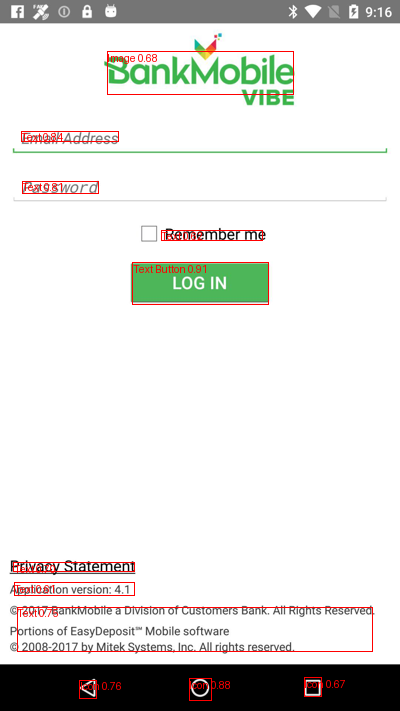

In [13]:
boxes =  pred[0]['boxes']
scores = pred[0]['scores']
labels = pred[0]['labels']
idx2Label = loadClassMap()
image = drawBoxesOnImage(test_image, boxes, labels, idx2Label, scores)
image

### Generate batch of predictions for evaluation test dataset
However, we can't only rely on visualizing the output on single screenshot. We need to be able to run an evaluation on a bunch of screenshots in our test dataset. To make this easier, we will precompute the predictions data for all of the screenshots and store it in the `predictions` directory. 

In [14]:
data = VINSUIDataModule()

gt = []
predictions = []

# Save the predictions for each screenshot into a text file for each screenshot, eg. 0.txt, along with their bounding box and confidence scores. 
# TextButton 0.7448743581771851 416 1662 251 95
# Text 0.7387557625770569 118 107 98 39
# Text 0.7260302305221558 216 280 643 71
# ....
count = 0
for sample in data.test_dataset: 
    if count > 100: 
        # To save time, lets only evaluate the first 100 screenshots. 
        break 
    count += 1
    img, target = sample 

    # Get predictions for the image. 
    pred = getPredictionsForImage(model, img)
    gt_labels = target['labels']
    gt_boxes = target['boxes']
    gt.append(gt_labels)
    pred_labels = pred[0]['labels'] 
    predictions.append(pred_labels) 

    boxes = pred[0]['boxes']
    labels = pred[0]['labels']
    scores = pred[0]['scores'] 
    image_id = int(target['image_id'])
    pred_path = os.path.join(PREDICTIONS_DIR, f"{image_id}.txt")
    gt_path = os.path.join(GROUND_TRUTH_DIR, f"{image_id}.txt")

    with open(pred_path, "w") as sample_file: 
        for i in range(len(boxes)):
            x1, y1, x2, y2 = boxes[i]
            score = scores[i]
            width = x2 - x1 
            height = y2 - y1 
            label = labels[i]
            className = idx2Label[str(int(labels[i]))]

            className = "".join(className.split(" "))
            result = f"{className} {score} {int(x1)} {int(y1)} {int(width)} {int(height)}\n"
            sample_file.write(result)

    with open(gt_path, "w") as gt_file: 
        for i in range(len(gt_boxes)):
            x1, y1, x2, y2 = gt_boxes[i]
            width = x2 - x1 
            height = y2 - y1 
            label = gt_labels[i]
            className = idx2Label[str(int(gt_labels[i]))]
            
            className = "".join(className.split(" "))
            result = f"{className} {int(x1)} {int(y1)} {int(width)} {int(height)}\n"
            gt_file.write(result)

gt_all = torch.cat(gt) 
pred_all = torch.cat(predictions)

### Metrics (mAP) 
Now, we are ready to compute the metrics. One metric we will compute is the `mAP`. 

`mAP` or "mean average precision" is the most common metric used to evaluate object detection algorithms. A detailed breakdown is covered in this article: https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52

If you have exposure to machine learning, you should be familiar with `precision` and `recall`. `mAP` not calculated by taking the average of the `precision` values as you may think. The `mAP` score is calculated by taking the mean `AP` (average precision) over all classes and all `IoU` thresholds. 

`IoU`, or intersection over union, is a measure of overlap between the detected box and the ground truth box as visualized below. 
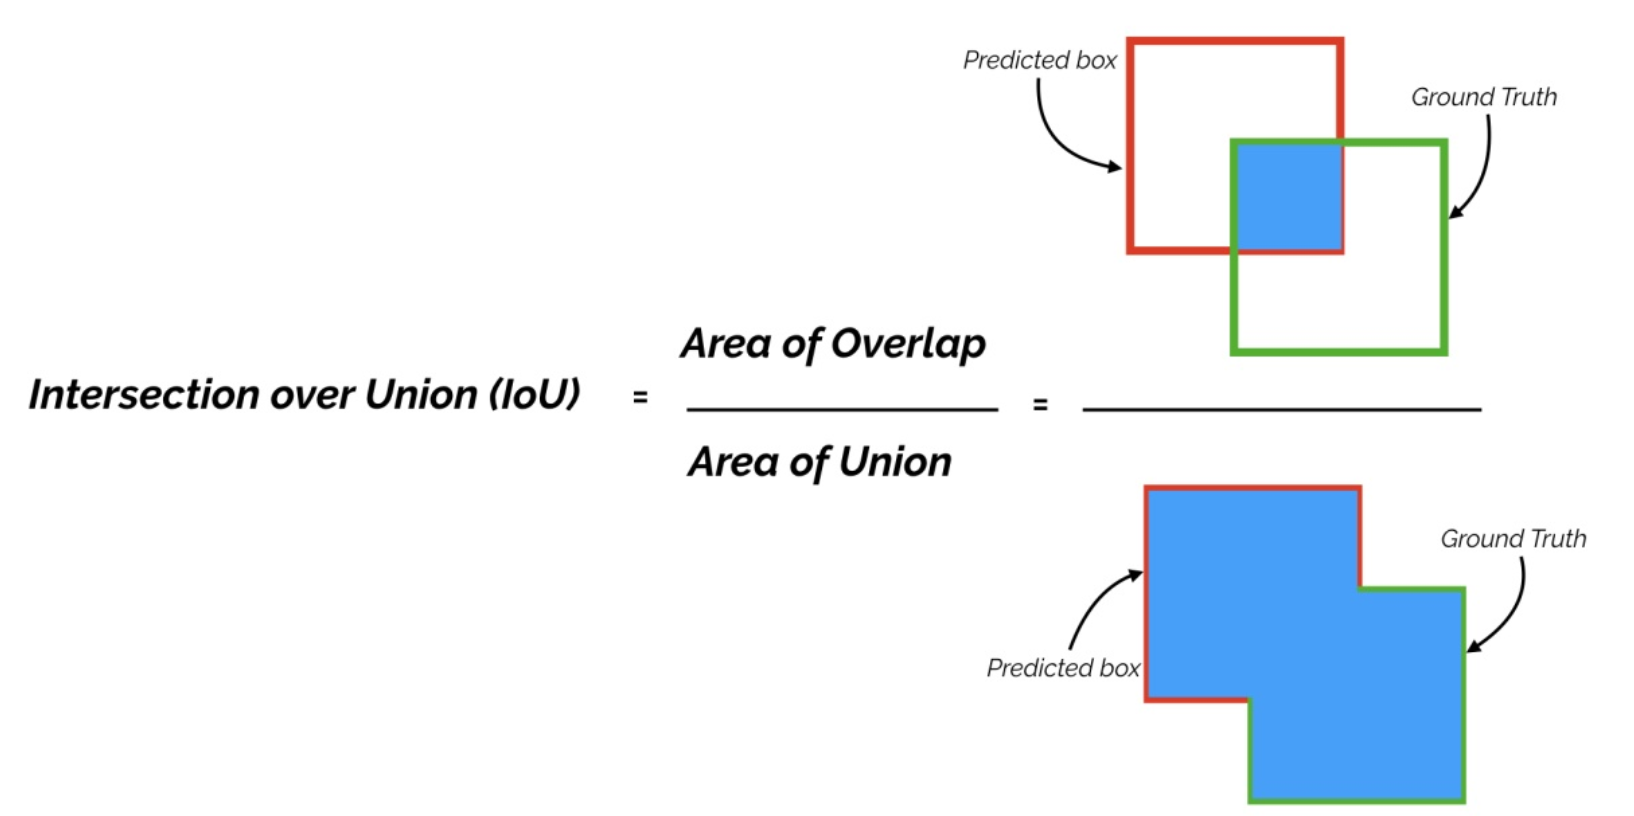


#### Choose matching method to compare detections to ground truth predictions

There are several different ways to decide which predictions match to which ground truth elements. We can match elements with the highest intersection over union (`IoU`), and set different thresholds for the minimum `IoU` for elements to be considered a match. 

In [29]:
# Define the set of iou thresholds we want to evaluate. 
iouThresholds = [round(x, 1) for x in np.arange(1, 0, -0.2)]
iouThresholds

[1.0, 0.8, 0.6, 0.4, 0.2]

In [16]:
# Evaluate VOC metrics
vocData = getVOCData(GROUND_TRUTH_DIR, PREDICTIONS_DIR)

In [17]:
results, allPredsMatched, allGTMatched = evaluateVOCData(vocData, iouThresholds=iouThresholds)

100%|███████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 705.79it/s]

100%|███████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 556.82it/s]

100%|███████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 937.97it/s]

100%|███████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 805.69it/s]

100%|███████████████████████████████████████████████████████████████████████████| 101/101 [00:00<00:00, 884.73it/s]

100%|████████████████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  4.61it/s]


#### Examine the results
Let's get an overview of what the output looks like.

There are two main things to evaluate:

1. Objectness - How well the model detected whether or not there was an element (i.e. "object").
2. Classification - How well the model decides on a detection's classification (e.g. "Text" or "Toggle")

#### High Level Results

The results offer a high-level overview of the performance for both through Average Precision (AP). 

Here we can see the objectness AP for each matching method:

In [18]:
results['Objectness Summary']

,Classification,Average Precision,Total Positives,Match Method,IOU Threshold
0,Object,0.000000,1464,IOU ≥ 1.0,1.0
1,Object,0.237803,1464,IOU ≥ 0.8,0.8
2,Object,0.728012,1464,IOU ≥ 0.6,0.6
3,Object,0.850927,1464,IOU ≥ 0.4,0.4
4,Object,0.878123,1464,IOU ≥ 0.2,0.2


We can see the classification APs in a similar way. Because there are many classification (versus one objectness) results, here's a snippet that focus on one of the matching methods.

In [19]:
clfSummary = results['Classification Summary']
clfSummary

,Classification,Average Precision,Total Positives,Match Method,IOU Threshold
0,Image,0.000000,166,IOU ≥ 1.0,1.0
1,Text,0.000000,694,IOU ≥ 1.0,1.0
2,TextButton,0.000000,103,IOU ≥ 1.0,1.0
3,PageIndicator,0.000000,31,IOU ≥ 1.0,1.0
4,InputField,0.000000,59,IOU ≥ 1.0,1.0
5,CheckedView,0.000000,24,IOU ≥ 1.0,1.0
6,OTHER,0.000000,89,IOU ≥ 1.0,1.0
7,Pop-UpWindow,0.000000,6,IOU ≥ 1.0,1.0
8,Icon,0.000000,263,IOU ≥ 1.0,1.0
9,SlidingMenu,0.000000,5,IOU ≥ 1.0,1.0


#### Low Level Results
We can also access the details of these results, which is especially helpful for examining confidence thresholds or generating PR curves.

In [20]:
results['Objectness Details']

,Confidence Threshold,True Positives,False Positives,Recall,Precision,Classification,Match Method,IOU Threshold
0,0.943235,0,1,0.000000,0.000000,Object,IOU ≥ 1.0,1.0
1,0.943184,0,2,0.000000,0.000000,Object,IOU ≥ 1.0,1.0
2,0.942821,0,3,0.000000,0.000000,Object,IOU ≥ 1.0,1.0
3,0.940094,0,4,0.000000,0.000000,Object,IOU ≥ 1.0,1.0
4,0.939965,0,5,0.000000,0.000000,Object,IOU ≥ 1.0,1.0
...,...,...,...,...,...,...,...,...
21000,0.200223,1355,2842,0.925546,0.322850,Object,IOU ≥ 0.2,0.2
21001,0.200172,1355,2843,0.925546,0.322773,Object,IOU ≥ 0.2,0.2
21002,0.200168,1355,2844,0.925546,0.322696,Object,IOU ≥ 0.2,0.2
21003,0.200128,1355,2845,0.925546,0.322619,Object,IOU ≥ 0.2,0.2


### Visualize PR and AP
Ok, we now are able to understand PR and AP for each class across various `IoU` thresholds. Lets create some visualizations to better understand how each class is performing. One way to do that is to create a `PR` curve, precision recall curve, which shows the tradeooff between `precision` and `recall` for various `IoU` thresholds. 

In [21]:
# Plotting function to create a PR curve using altair library. 
def plotPRCurve(dataFrame, downsampleSize=None):
    # Downsize if requested to.
    if downsampleSize:
        dataFrame = downsample(dataFrame, maxCountPerGroup=downsampleSize)

    # Prepare the tooltip.
    showClassification = ("Classification" in dataFrame) and (
        len(dataFrame["Classification"].unique()) > 1
    )
    tooltipInfo = ["Confidence Threshold", "Precision", "Recall"]
    if showClassification:
        tooltipInfo.append("Classification")

    # Draw the basic line.
    line = (
        alt.Chart(dataFrame)
        .mark_line()
        .encode(
            x=alt.X("Recall", scale=alt.Scale(domain=(0, 1))),
            y=alt.Y("Precision", scale=alt.Scale(domain=(0, 1))),
            color="Classification",
        )
    )

    # Draw points on the line, and highlight the one nearest the mouse.
    nearest = alt.selection_point(on="mouseover", nearest=True)
    points = (
        line.mark_point()
        .encode(
            opacity=alt.condition(~nearest, alt.value(0), alt.value(1)),
            tooltip=tooltipInfo,
        )
        .add_params(nearest)
    )

    # Put it all together.
    chart = (line + points)
    field = "Match Method"
    options = sorted(dataFrame[field].unique())
    dropdownMenu = alt.binding_select(options=options)
    selection = alt.selection_point(
        fields=[field], bind=dropdownMenu, name="Choice of"
    )

    prCurve = chart.add_params(selection).transform_filter(selection)
        
    return prCurve

In [22]:
alt.Chart(results['Classification Summary']).mark_bar().encode(
    x = 'Classification',
    y = 'Total Positives',
    tooltip = ['Classification', 'Total Positives']
)

alt.Chart(...)

Create a PR curve for objectness - or whether a UI element is there or not -- but not yet considering the class of each UI element. 

In [23]:
plotPRCurve(results['Objectness Details'], downsampleSize=5000)

alt.LayerChart(...)

#### View the PR curve for specific UI element classes
Above, we looked at the PR curve for `Objectness`. However, the PR curve may look very different for different UI element classes. Let's take a look at the "TextButton" class. Specify the classname below after `==` to extract the part of the data frame for "TextButton". 

In [24]:
results['Classification Details']
text_buttons = results['Classification Details'].loc[results['Classification Details']['Classification'] == "TextButton"]

In [25]:
plotPRCurve(text_buttons, downsampleSize=5000)

alt.LayerChart(...)

### Visualize a confusion matrix 

We may also want to understand if there are any classes that confuse the model where they are commonly predicted as the other, 
such as Icon / Image, etc. To do this, we can create a confusion matrix. 

In [26]:
# Collect all matched boxes into pred_class,gt_class
pred_class = allPredsMatched[0]
gt_class = allGTMatched[0]

In [27]:
# Plot confusion matrix 
labels = [label for label in idx2Label.values()]
print(labels)
cm = confusion_matrix(gt_class, pred_class, labels=labels)

['OTHER', 'Background Image', 'Checked View', 'Icon', 'Input Field', 'Image', 'Text', 'Text Button', 'Page Indicator', 'Pop-Up Window', 'Sliding Menu', 'Switch', 'BACKGROUND']


In [28]:
print("Confusion Matrix:")
print(cm)

Confusion Matrix:
[[  8   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0 228   0  13   1   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0  16   0 140   1   0   0   0   0   0   0]
 [  0   0   0   5   0   6 683   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   1   0   0   0   0   8   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0]]


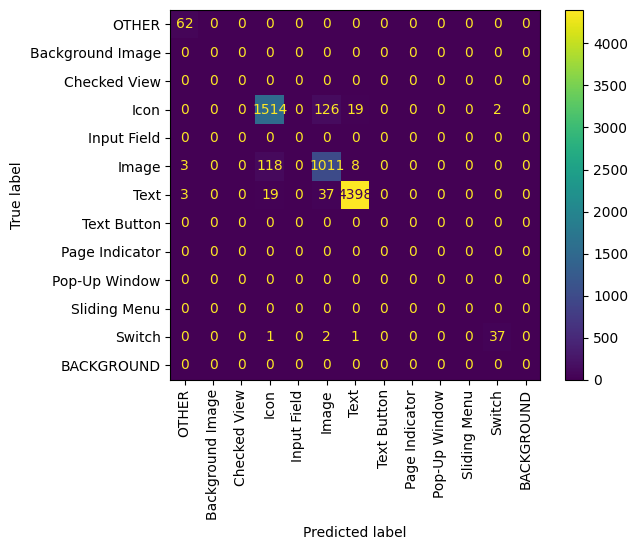

In [30]:
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels).plot(xticks_rotation="vertical")

In the confusion matrix, we can see that a common mistake the model makes is confusion the `Icon` class with the `Image` class and vice versa given the high number of samples in those boxes. Another common confusion is `Text` and `Icon`. To address these, you can use data augmentation to synthesize more examples of the classes, add more training data, or adjust the model architecture. 